In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import dsa
from dsa import *
from datasets import image
from models import resnet
import pickle

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


2022-03-25 19:06:24.109321: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-25 19:06:25.291348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10545 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [4]:
target_ds, aux_ds = image.load_cifar_vs_celeba()

In [5]:
cifar_celeba_dsa = {}
log = {}

In [9]:
# this is for 40 labels binary classification
for split in [4]:
    make_f, make_g, make_e, make_d, make_c = resnet.make_resnet(split=split, units=40, act='sigmoid')
    cifar_celeba_dsa["cifar-celeba-split="+str(split)] = dsa(target_ds=target_ds, aux_ds=aux_ds)
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    log["cifar-celea-split="+str(split)] = cifar_celeba_dsa["cifar-celeba-split="+str(split)].dsa_attack(
        make_f=make_f,
        make_g=make_g,
        lr=0.001,
        batch_size=64,
        iterations=30000,
        make_e=make_e,
        make_d=make_d,
        make_c=make_c,
        lr_e=0.0012, # learning rate of the encoder/decoder/critic is set to be smaller
        lr_d=0.0001,
        lr_c=0.001,
        iter_d=40,   # the number of iterations to train the decoder on auxiliary data
        w=500.,
        verbose=True,
        log_freq=500)

======Split level is 4======
Iteration 500, average attack MSE: 0.3728657822608948
Iteration 1000, average attack MSE: 0.16181490747630597
Iteration 1500, average attack MSE: 0.1419982567578554


KeyboardInterrupt: 

In [9]:
with open('log/cifar_vs_celeba.pkl', 'wb') as f:
    pickle.dump(log, f)

tf.Tensor(0.0895134, shape=(), dtype=float32)


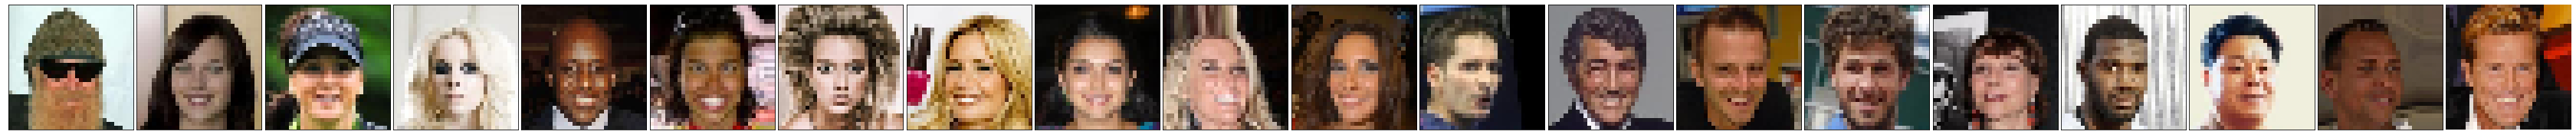

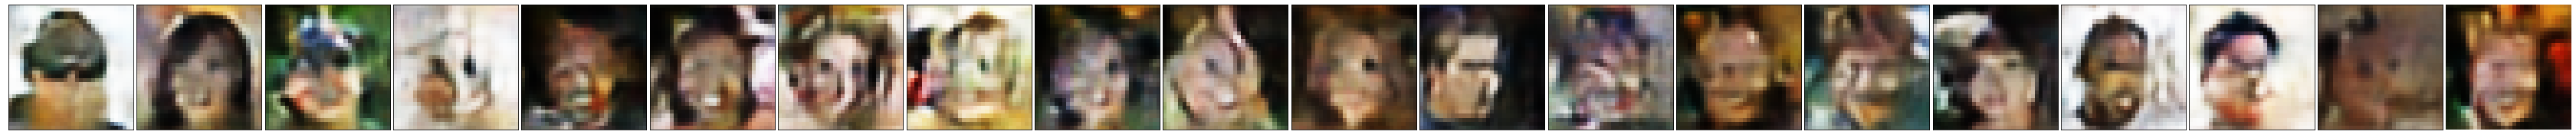

In [11]:
# imgs = image.load_celeba(take_first=20)

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno')
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
    return fig

fig = plot(imgs)
for split in [4]:
    flattened_z = cifar_celeba_dsa["cifar-celeba-split="+str(split)].f(imgs, training=False).numpy().reshape((len(imgs), cifar_celeba_dsa["cifar-celeba-split="+str(split)].flattened_inter_dim))
    rec_res = cifar_celeba_dsa["cifar-celeba-split="+str(split)].d(flattened_z, training=False)
    fig = plot(rec_res)
    print(tf.keras.losses.MeanSquaredError()(imgs, rec_res))

tf.Tensor(0.08502613, shape=(), dtype=float32)


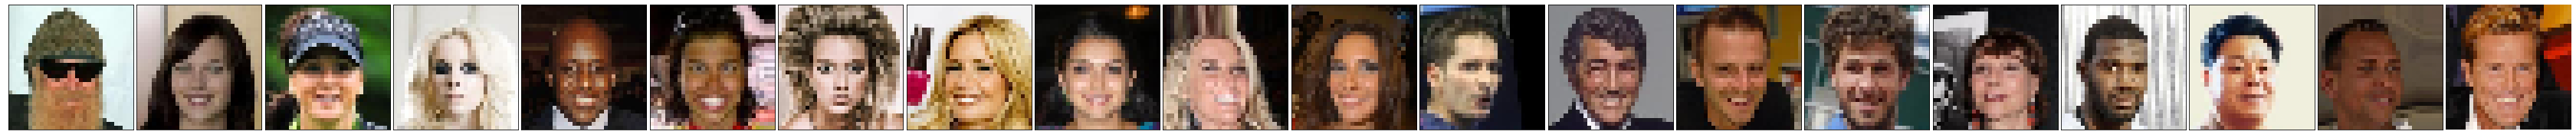

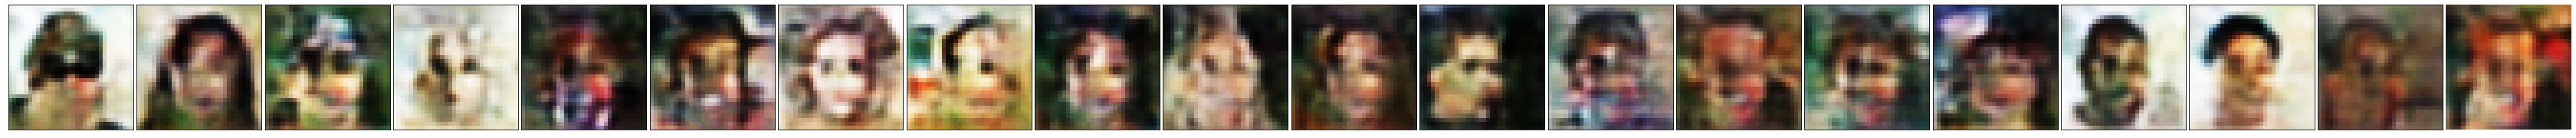

In [18]:
# imgs = image.load_celeba(take_first=20)

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno')
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
    return fig

fig = plot(imgs)
for split in [4]:
    flattened_z = cifar_celeba_dsa["cifar-celeba-split="+str(split)].f(imgs, training=False).numpy().reshape((len(imgs), cifar_celeba_dsa["cifar-celeba-split="+str(split)].flattened_inter_dim))
    rec_res = cifar_celeba_dsa["cifar-celeba-split="+str(split)].d(flattened_z, training=False)
    fig = plot(rec_res)
    print(tf.keras.losses.MeanSquaredError()(imgs, rec_res))

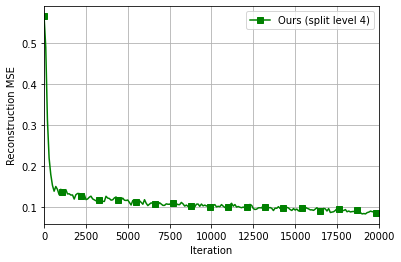

In [13]:
# with open('log/cifar_vs_celeba.pkl', 'rb') as f:
#     log = pickle.load(f)

from matplotlib.pyplot import figure

log_freq = 100
# plt.yscale('logit')
plt.xlim([0,20000])
# plt.ylim([0.0, 0.5])
plt.grid()
# plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], labels=["0.05", "0.1", "0.15", "0.2", "0.25", "0.3", "0.35", "0.4"])
# sampled_log_2 = [sum(log["cat_vs_dog-split=2"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["cat_vs_dog-split=2"][:,0])/log_freq))]
# sampled_log_3 = [sum(log["cat_vs_dog-split=3"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["cat_vs_dog-split=3"][:,0])/log_freq))]
sampled_log_4 = [sum(log["cifar-celea-split=4"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["cifar-celea-split=4"][:,0])/log_freq))]
ran = [i * log_freq for i in range(int(20000/log_freq))]
plt.plot(
    # ran, sampled_log_2, 'ro-',
    # ran, sampled_log_3, 'b^-',
    ran, sampled_log_4, 'gs-',
    markevery=11)
plt.ylabel('Reconstruction MSE')
plt.xlabel('Iteration')
plt.legend([
    # "Ours (split level 2)",
    # "Ours (split level 3)",
    "Ours (split level 4)"])
# plt.savefig("fig/cifar-celeba-dsa.pdf", bbox_inches='tight')

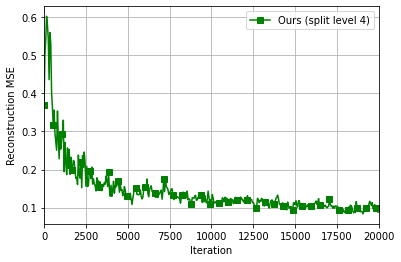

In [17]:
# with open('log/cifar_vs_celeba.pkl', 'rb') as f:
#     log = pickle.load(f)

from matplotlib.pyplot import figure

log_freq = 50
# plt.yscale('logit')
plt.xlim([0,20000])
# plt.ylim([0.0, 0.5])
plt.grid()
# plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], labels=["0.05", "0.1", "0.15", "0.2", "0.25", "0.3", "0.35", "0.4"])
# sampled_log_2 = [sum(log["cat_vs_dog-split=2"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["cat_vs_dog-split=2"][:,0])/log_freq))]
# sampled_log_3 = [sum(log["cat_vs_dog-split=3"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["cat_vs_dog-split=3"][:,0])/log_freq))]
sampled_log_4 = [sum(log["cifar-celea-split=4"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["cifar-celea-split=4"][:,0])/log_freq))]
ran = [i * log_freq for i in range(int(20000/log_freq))]
plt.plot(
    # ran, sampled_log_2, 'ro-',
    # ran, sampled_log_3, 'b^-',
    ran, sampled_log_4, 'gs-',
    markevery=11)
plt.ylabel('Reconstruction MSE')
plt.xlabel('Iteration')
plt.legend([
    # "Ours (split level 2)",
    # "Ours (split level 3)",
    "Ours (split level 4)"])
# plt.savefig("fig/cifar-celeba-dsa.pdf", bbox_inches='tight')